## **Install packages**

In [ ]:
! pip install datasets
! pip install transformers
! pip install rouge.score nltk py7zr bertviz umap-learn
! pip install accelerate sentencepiece urllib3
! pip install evaluate
! pip install rouge_score
! pip install huggingface_hub
# !pip install transformers[sentencepiece] datasets evaluate rouge_score py7zr -q
# !pip install transformers[torch]
! pip install pandas numpy matplotlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 527.3/527.3 kB 12.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 8.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.9/39.9 MB 17.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 16.3 MB/s eta 0:00:00
  Attempting uninstall: pyarrow
    Found existing installation: pyarrow 14.0.2
    Uninstalling pyarrow-14.0.2:
      Successfully uninstalled pyarrow-14.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf-cu12 24.4.1 requires pyarrow<15.0.0a0,>=14.0.1, but you have pyarrow 17.0.0 which is incompatible.
ibis-framework 8.0.0 requires pyarrow<16,>=2, but you have pyarrow 17.0.0 which is incompatible.
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━

## **Login to HuggingFace**

In [ ]:
from huggingface_hub import login
login()

## **Dataset Prep**

**Processing Dataset (only keeping records with input text within 1024 tokens)**

In [ ]:
from datasets import load_dataset
from datasets import concatenate_datasets
from transformers import AutoModelForSeq2SeqLM, AutoTokenizer
from datasets import DatasetDict


# Load tokenizer and model
tokenizer = AutoTokenizer.from_pretrained("facebook/bart-large-cnn")
model = AutoModelForSeq2SeqLM.from_pretrained("facebook/bart-large-cnn")

# Filter function
def filter_function(example):
    # Check if the article is empty
    if not example['article'].strip():
        return False

    # Tokenize the article and check length
    token_length = len(tokenizer(example['article'], truncation=False)['input_ids'])
    return token_length <= 1024

# Load datasets
dataset1 = load_dataset('bakhitovd/ML_arxiv') # Machine Learning papers
dataset2 = load_dataset('ccdv/pubmed-summarization') # Medical papers

# Combine the datasets
combined_dataset = concatenate_datasets([dataset1, dataset2])

# Apply filter to all splits
filtered_dataset = {}
for split in combined_dataset.keys():
    filtered_dataset[split] = combined_dataset[split].filter(filter_function)


print(filtered_dataset)


In [ ]:
# Convert to DatasetDict
final_dataset = DatasetDict(filtered_dataset)

# Push the dataset to the Hugging Face Hub
final_dataset.push_to_hub('shruti28062000/combined_filtered_dataset')

## **EDA on Filtered Training Dataset**

Generating train split:   0%|          | 0/6088 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/294 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/314 [00:00<?, ? examples/s]

array([[<Axes: title={'center': 'Validation Article Length'}>,
        <Axes: title={'center': 'Validation Abstract Length'}>]],
      dtype=object)

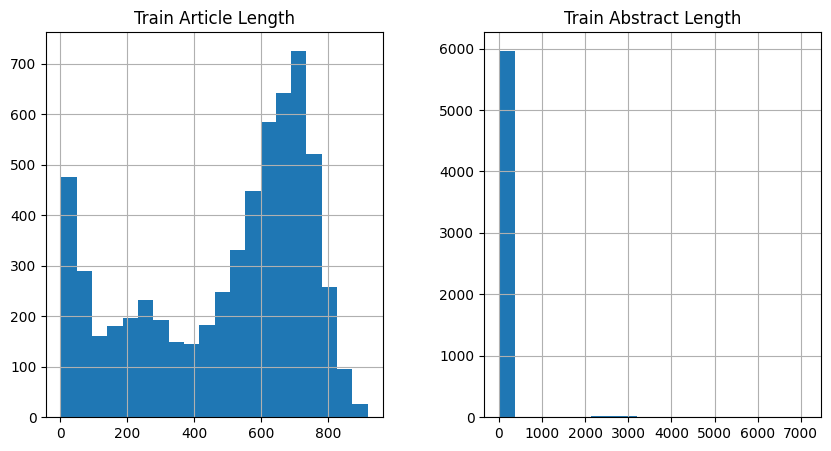

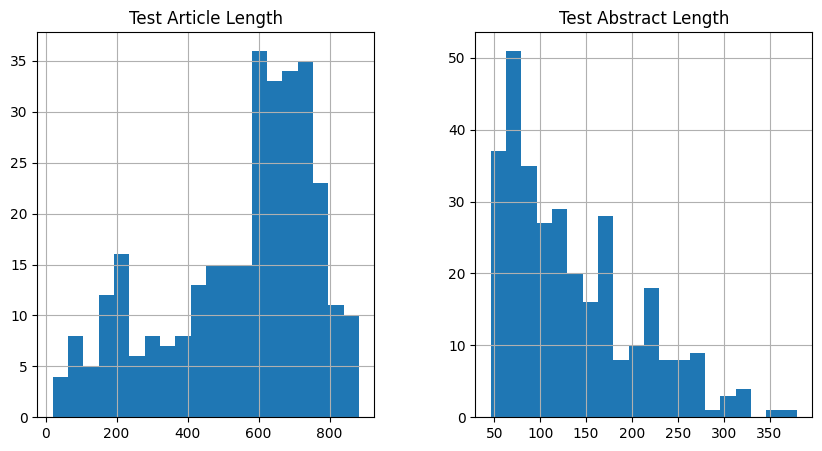

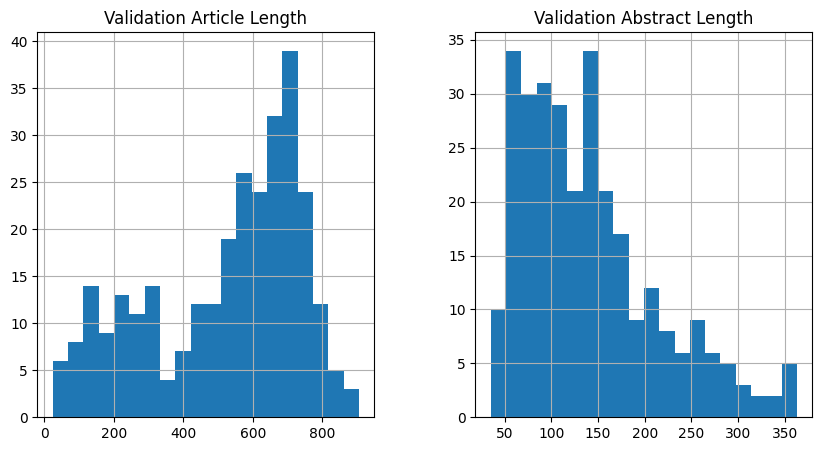

In [ ]:
from datasets import load_dataset
import pandas as pd

# Load the dataset splits
dataset = load_dataset('shruti28062000/combined_filtered_dataset')

train_split = dataset['train']
test_split = dataset['test']
validation_split = dataset['validation']

# Function to calculate word lengths for the 'article' and 'abstract' fields
def calculate_word_lengths(split):
    article_lengths = [len(example['article'].split()) for example in split]
    abstract_lengths = [len(example['abstract'].split()) for example in split]
    return article_lengths, abstract_lengths

# Calculate word lengths for each split
train_article_lengths, train_abstract_lengths = calculate_word_lengths(train_split)
test_article_lengths, test_abstract_lengths = calculate_word_lengths(test_split)
validation_article_lengths, validation_abstract_lengths = calculate_word_lengths(validation_split)

# Create separate DataFrames for each split
train_data = pd.DataFrame({
    'Train Article Length': train_article_lengths,
    'Train Abstract Length': train_abstract_lengths
})

test_data = pd.DataFrame({
    'Test Article Length': test_article_lengths,
    'Test Abstract Length': test_abstract_lengths
})

validation_data = pd.DataFrame({
    'Validation Article Length': validation_article_lengths,
    'Validation Abstract Length': validation_abstract_lengths
})

# Plot histograms for each split
train_data.hist(figsize=(10, 5), bins=20)
test_data.hist(figsize=(10, 5), bins=20)
validation_data.hist(figsize=(10, 5), bins=20)


In [ ]:
from datasets import load_dataset
import pandas as pd
import numpy as np

# Load the dataset splits
dataset = load_dataset('shruti28062000/combined_filtered_dataset')

train_split = dataset['train']
test_split = dataset['test']
validation_split = dataset['validation']

# Function to calculate word count statistics for the 'article' and 'abstract' fields
def calculate_word_count_statistics(split):
    article_word_counts = [len(example['article'].split()) for example in split]
    abstract_word_counts = [len(example['abstract'].split()) for example in split]

    def calculate_statistics(counts):
        min_count = np.min(counts)
        max_count = np.max(counts)
        avg_count = np.mean(counts)
        percentile_90 = np.percentile(counts, 90)
        return min_count, max_count, avg_count, percentile_90

    article_stats = calculate_statistics(article_word_counts)
    abstract_stats = calculate_statistics(abstract_word_counts)

    return article_stats, abstract_stats

# Calculate word count statistics for each split
train_article_stats, train_abstract_stats = calculate_word_count_statistics(train_split)
test_article_stats, test_abstract_stats = calculate_word_count_statistics(test_split)
validation_article_stats, validation_abstract_stats = calculate_word_count_statistics(validation_split)

# Create DataFrames for each split
train_data = pd.DataFrame({
    'Statistic': ['Min Word Count', 'Max Word Count', 'Avg Word Count', '90th Percentile'],
    'Train Article': train_article_stats,
    'Train Abstract': train_abstract_stats
})

test_data = pd.DataFrame({
    'Statistic': ['Min Word Count', 'Max Word Count', 'Avg Word Count', '90th Percentile'],
    'Test Article': test_article_stats,
    'Test Abstract': test_abstract_stats
})

validation_data = pd.DataFrame({
    'Statistic': ['Min Word Count', 'Max Word Count', 'Avg Word Count', '90th Percentile'],
    'Validation Article': validation_article_stats,
    'Validation Abstract': validation_abstract_stats
})

# Style the DataFrames
train_styled = train_data.style.set_table_styles([
    {'selector': 'thead th', 'props': [('font-weight', 'bold')]},
    {'selector': 'th, td', 'props': [('border', '1px solid black')]}
])

test_styled = test_data.style.set_table_styles([
    {'selector': 'thead th', 'props': [('font-weight', 'bold')]},
    {'selector': 'th, td', 'props': [('border', '1px solid black')]}
])

validation_styled = validation_data.style.set_table_styles([
    {'selector': 'thead th', 'props': [('font-weight', 'bold')]},
    {'selector': 'th, td', 'props': [('border', '1px solid black')]}
])

# Display the styled DataFrames one by one
print("Train Dataset")
display(train_styled)
print()
print("Validation Dataset")
display(validation_styled)
print()
print("Test Dataset")
display(test_styled)



Train Dataset


,Statistic,Train Article,Train Abstract
0,Min Word Count,3.000000,15.000000
1,Max Word Count,918.000000,7114.000000
2,Avg Word Count,491.862188,187.214028
3,90th Percentile,756.000000,256.000000



Validation Dataset


,Statistic,Validation Article,Validation Abstract
0,Min Word Count,24.000000,35.000000
1,Max Word Count,905.000000,363.000000
2,Avg Word Count,520.911565,140.544218
3,90th Percentile,751.000000,255.100000



Test Dataset


,Statistic,Test Article,Test Abstract
0,Min Word Count,20.000000,46.000000
1,Max Word Count,883.000000,380.000000
2,Avg Word Count,550.589172,133.458599
3,90th Percentile,770.100000,235.800000


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating train split:   0%|          | 0/6088 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/294 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/314 [00:00<?, ? examples/s]

train - Article 90th Percentile: 756.0
train - Abstract 90th Percentile: 256.0
train - Article Min Word Count: 3
train - Article Max Word Count: 918
train - Article Avg Word Count: 491.86
train - Abstract Min Word Count: 15
train - Abstract Max Word Count: 7114
train - Abstract Avg Word Count: 187.21


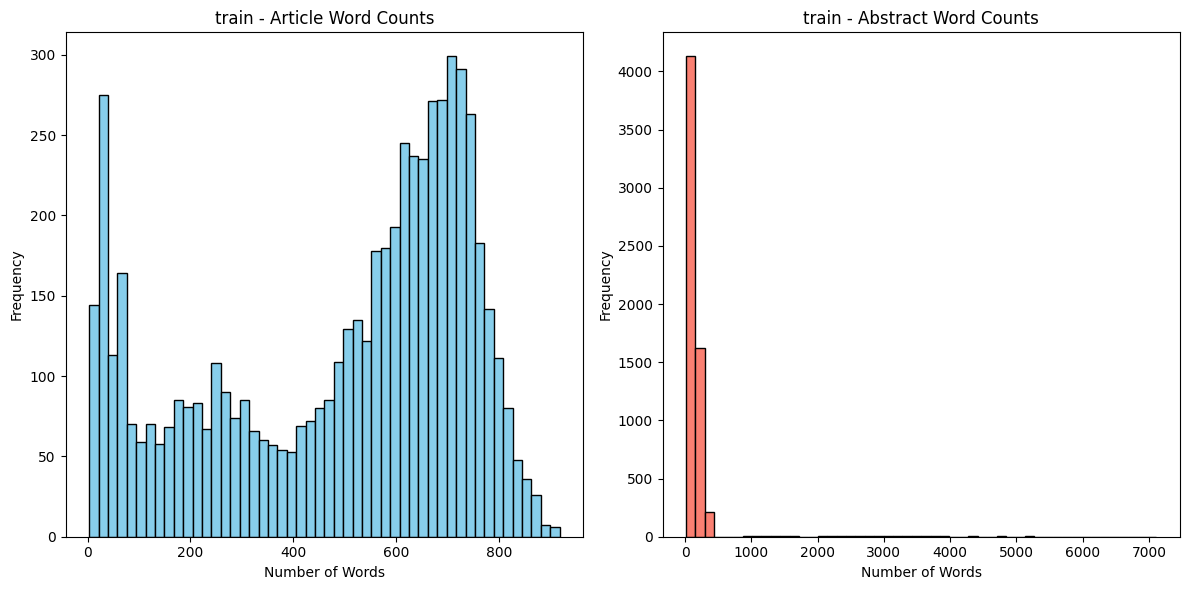

validation - Article 90th Percentile: 751.0
validation - Abstract 90th Percentile: 255.09999999999997
validation - Article Min Word Count: 24
validation - Article Max Word Count: 905
validation - Article Avg Word Count: 520.91
validation - Abstract Min Word Count: 35
validation - Abstract Max Word Count: 363
validation - Abstract Avg Word Count: 140.54


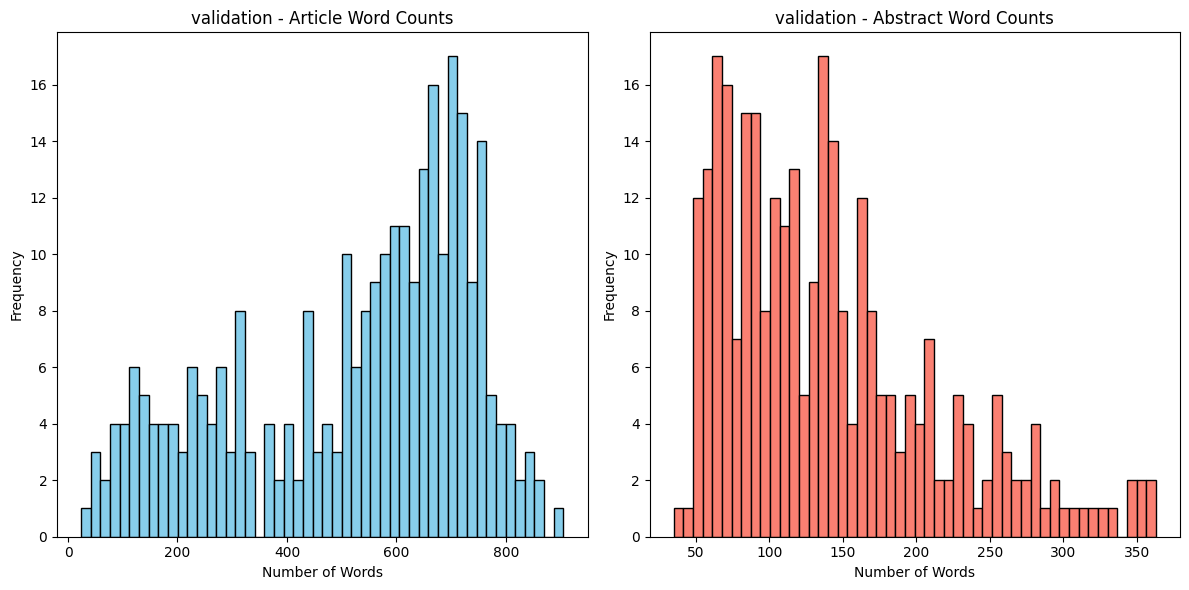

test - Article 90th Percentile: 770.0999999999999
test - Abstract 90th Percentile: 235.79999999999995
test - Article Min Word Count: 20
test - Article Max Word Count: 883
test - Article Avg Word Count: 550.59
test - Abstract Min Word Count: 46
test - Abstract Max Word Count: 380
test - Abstract Avg Word Count: 133.46


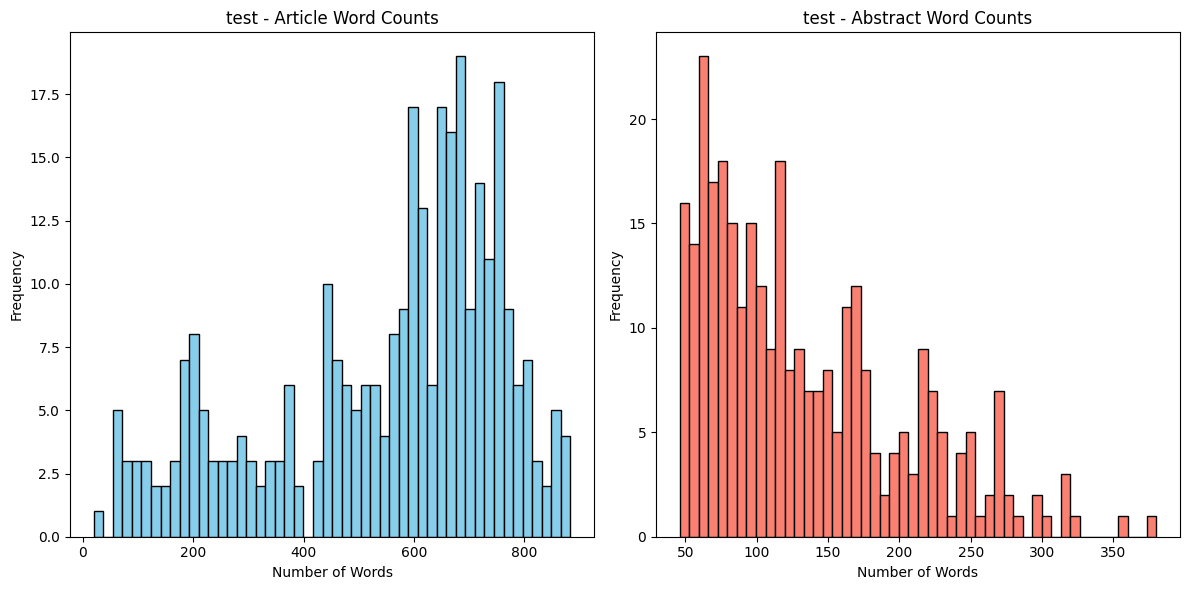

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
from datasets import load_dataset

dataset = load_dataset('shruti28062000/combined_filtered_dataset')

# Function to count words in a text
def count_words(text):
    return len(text.split())

# Calculate word counts, percentiles, and plot histograms
for split, dataset in dataset.items():
    # Extract the articles and abstracts
    articles = dataset['article']
    abstracts = dataset['abstract']

    # Calculate word counts
    article_word_counts = [count_words(article) for article in articles]
    abstract_word_counts = [count_words(abstract) for abstract in abstracts]

    # Calculate statistics for word counts
    def calculate_statistics(counts):
        min_count = np.min(counts)
        max_count = np.max(counts)
        avg_count = np.mean(counts)
        return min_count, max_count, avg_count

    article_min_count, article_max_count, article_avg_count = calculate_statistics(article_word_counts)
    abstract_min_count, abstract_max_count, abstract_avg_count = calculate_statistics(abstract_word_counts)

    # Calculate 90th percentiles
    article_90th_percentile = np.percentile(article_word_counts, 90)
    abstract_90th_percentile = np.percentile(abstract_word_counts, 90)

    # Print the statistics
    print(f'{split} - Article 90th Percentile: {article_90th_percentile}')
    print(f'{split} - Abstract 90th Percentile: {abstract_90th_percentile}')

    print(f'{split} - Article Min Word Count: {article_min_count}')
    print(f'{split} - Article Max Word Count: {article_max_count}')
    print(f'{split} - Article Avg Word Count: {article_avg_count:.2f}')

    print(f'{split} - Abstract Min Word Count: {abstract_min_count}')
    print(f'{split} - Abstract Max Word Count: {abstract_max_count}')
    print(f'{split} - Abstract Avg Word Count: {abstract_avg_count:.2f}')

    # Plot histograms
    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plt.hist(article_word_counts, bins=50, color='skyblue', edgecolor='black')
    plt.title(f'{split} - Article Word Counts')
    plt.xlabel('Number of Words')
    plt.ylabel('Frequency')

    plt.subplot(1, 2, 2)
    plt.hist(abstract_word_counts, bins=50, color='salmon', edgecolor='black')
    plt.title(f'{split} - Abstract Word Counts')
    plt.xlabel('Number of Words')
    plt.ylabel('Frequency')

    plt.tight_layout()
    plt.show()


## **BART Finetune Trial 1 (2 epochs)**

### **Trial 1: 2 epochs**

In [ ]:
import transformers
import evaluate
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM, Seq2SeqTrainingArguments, Seq2SeqTrainer
from datasets import load_dataset
from evaluate import load
import numpy as np
import nltk
nltk.download('punkt')
from datasets import concatenate_datasets

max_length = 1024
batch_size = 2
model_ckpts = "facebook/bart-large-cnn"

# Load dataset
data = load_dataset("shruti28062000/combined_filtered_dataset")

train_data = data['train']
val_data = data['validation']
test_data = data['test']
val_data = concatenate_datasets([val_data, test_data])

# Tokenizer
tokenizer = AutoTokenizer.from_pretrained(model_ckpts)


def prep_data(data_to_prep):
  # get all the inputs
  inputs = [article for article in data_to_prep['article']]
  # tokenize the inputs
  model_inputs = tokenizer(inputs,  max_length=max_length, padding='max_length', truncation=True)

  # tokenize the outputs
  with tokenizer.as_target_tokenizer():
    targets = tokenizer(data_to_prep['abstract'], max_length=max_length, padding='max_length', truncation=True)

  # set labels
  model_inputs['labels'] = targets['input_ids']
  # return the tokenized data
  # input_ids, attention_mask and labels
  return model_inputs

tokenized_train_data = train_data.map(prep_data, batched = True, remove_columns=['article', 'abstract'])
tokenized_val_data = val_data.map(prep_data, batched = True, remove_columns=['article', 'abstract'])

# Load model
model = AutoModelForSeq2SeqLM.from_pretrained(model_ckpts)

# Collator to create batches and preprocess data with the tokenizer
collator = transformers.DataCollatorForSeq2Seq(tokenizer, model=model)

# ROUGE metric
metric = load("rouge")

def compute_rouge_scores(pred):
  predictions, labels = pred
  # Decode predictions
  decode_preds = tokenizer.batch_decode(predictions, skip_special_tokens=True)
  # Decode labels
  decode_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)

  # Compute Results
  res = metric.compute(predictions=decode_preds, references=decode_labels, use_stemmer=True)
  res = {key: value * 100 for key, value in res.items()}

  return {k: round(v, 4) for k, v in res.items()}

# Training Arguments
args = Seq2SeqTrainingArguments(
    output_dir = 'bart_finetuned_papers_2e',
    eval_strategy='epoch',
    learning_rate=2e-5,
    per_device_train_batch_size=2,
    per_device_eval_batch_size= 2,
    gradient_accumulation_steps=2,
    weight_decay=0.01,
    save_total_limit=2,
    num_train_epochs=2,
    predict_with_generate=True,
    eval_accumulation_steps=2,
    fp16=True #available only with CUDA
    )

trainer = Seq2SeqTrainer(
    model,
    args,
    train_dataset=tokenized_train_data,
    eval_dataset=tokenized_val_data,
    data_collator=collator,
    tokenizer=tokenizer,
    compute_metrics=compute_rouge_scores
)


trainer.train()

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating train split:   0%|          | 0/6088 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/294 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/314 [00:00<?, ? examples/s]

config.json:   0%|          | 0.00/1.58k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Map:   0%|          | 0/6088 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:4016: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(


Map:   0%|          | 0/608 [00:00<?, ? examples/s]

model.safetensors:   0%|          | 0.00/1.63G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/363 [00:00<?, ?B/s]

Epoch,Training Loss,Validation Loss,Rouge1,Rouge2,Rougel,Rougelsum
1,0.425600,0.332229,39.311200,18.928700,26.785600,34.801500
2,0.372800,0.325917,39.519900,19.077000,26.974800,35.079300


Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 142, 'min_length': 56, 'early_stopping': True, 'num_beams': 4, 'length_penalty': 2.0, 'no_repeat_ngram_size': 3, 'forced_bos_token_id': 0, 'forced_eos_token_id': 2}
Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 142, 'min_length': 56, 'early_stopping': True, 'num_beams': 4, 'length_penalty': 2.0, 'no_repeat_ngram_size': 3, 'forced_bos_token_id': 0, 'forced_eos_token_

TrainOutput(global_step=3044, training_loss=0.44906820229569183, metrics={'train_runtime': 4073.7798, 'train_samples_per_second': 2.989, 'train_steps_per_second': 0.747, 'total_flos': 2.638666563531571e+16, 'train_loss': 0.44906820229569183, 'epoch': 2.0})

In [ ]:
trainer.save_model('bart_finetuned_papers_2e')
!zip bart_finetuned_papers_2e.zip -r bart_finetuned_papers_2e/

Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 142, 'min_length': 56, 'early_stopping': True, 'num_beams': 4, 'length_penalty': 2.0, 'no_repeat_ngram_size': 3, 'forced_bos_token_id': 0, 'forced_eos_token_id': 2}


  adding: bart_finetuned_papers_2e/ (stored 0%)
  adding: bart_finetuned_papers_2e/model.safetensors (deflated 7%)
  adding: bart_finetuned_papers_2e/checkpoint-3044/ (stored 0%)
  adding: bart_finetuned_papers_2e/checkpoint-3044/trainer_state.json (deflated 64%)
  adding: bart_finetuned_papers_2e/checkpoint-3044/model.safetensors (deflated 7%)
  adding: bart_finetuned_papers_2e/checkpoint-3044/special_tokens_map.json (deflated 52%)
  adding: bart_finetuned_papers_2e/checkpoint-3044/scheduler.pt (deflated 55%)
  adding: bart_finetuned_papers_2e/checkpoint-3044/merges.txt (deflated 53%)
  adding: bart_finetuned_papers_2e/checkpoint-3044/vocab.json (deflated 59%)
  adding: bart_finetuned_papers_2e/checkpoint-3044/training_args.bin (deflated 51%)
  adding: bart_finetuned_papers_2e/checkpoint-3044/config.json (deflated 61%)
  adding: bart_finetuned_papers_2e/checkpoint-3044/tokenizer_config.json (deflated 75%)
  adding: bart_finetuned_papers_2e/checkpoint-3044/rng_state.pth (deflated 25%)


## **BART Finetune Trial 2 (4 epochs)**

**Fine-tuning BART-CNN model on the newly created filtered dataset**

In [ ]:
import transformers
import evaluate
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM, Seq2SeqTrainingArguments, Seq2SeqTrainer
from datasets import load_dataset
from evaluate import load
import numpy as np
import nltk
nltk.download('punkt')
from datasets import concatenate_datasets

max_length = 1024
batch_size = 2
model_ckpts = "facebook/bart-large-cnn"

# Load dataset
data = load_dataset("shruti28062000/combined_filtered_dataset")

train_data = data['train']
val_data = data['validation']
test_data = data['test']
val_data = concatenate_datasets([val_data, test_data])

# Tokenizer
tokenizer = AutoTokenizer.from_pretrained(model_ckpts)


def prep_data(data_to_prep):
  # get all the inputs
  inputs = [article for article in data_to_prep['article']]
  # tokenize the inputs
  model_inputs = tokenizer(inputs,  max_length=max_length, padding='max_length', truncation=True)

  # tokenize the outputs
  with tokenizer.as_target_tokenizer():
    targets = tokenizer(data_to_prep['abstract'], max_length=max_length, padding='max_length', truncation=True)

  # set labels
  model_inputs['labels'] = targets['input_ids']
  # return the tokenized data
  # input_ids, attention_mask and labels
  return model_inputs

tokenized_train_data = train_data.map(prep_data, batched = True, remove_columns=['article', 'abstract'])
tokenized_val_data = val_data.map(prep_data, batched = True, remove_columns=['article', 'abstract'])

# Load model
model = AutoModelForSeq2SeqLM.from_pretrained(model_ckpts)

# Collator to create batches and preprocess data with the tokenizer
collator = transformers.DataCollatorForSeq2Seq(tokenizer, model=model)

# ROUGE metric
metric = load("rouge")

def compute_rouge_scores(pred):
  predictions, labels = pred
  # Decode predictions
  decode_preds = tokenizer.batch_decode(predictions, skip_special_tokens=True)
  # Decode labels
  decode_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)

  # Compute Results
  res = metric.compute(predictions=decode_preds, references=decode_labels, use_stemmer=True)
  res = {key: value * 100 for key, value in res.items()}

  return {k: round(v, 4) for k, v in res.items()}

# Training Arguments
args = Seq2SeqTrainingArguments(
    output_dir = 'bart_finetuned_papers_4e',
    eval_strategy='epoch',
    learning_rate=2e-5,
    per_device_train_batch_size=2,
    per_device_eval_batch_size= 2,
    gradient_accumulation_steps=2,
    weight_decay=0.01,
    save_total_limit=2,
    num_train_epochs=4,
    predict_with_generate=True,
    eval_accumulation_steps=2,
    fp16=True #available only with CUDA
    )

trainer = Seq2SeqTrainer(
    model,
    args,
    train_dataset=tokenized_train_data,
    eval_dataset=tokenized_val_data,
    data_collator=collator,
    tokenizer=tokenizer,
    compute_metrics=compute_rouge_scores
)


trainer.train()

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Map:   0%|          | 0/608 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:4016: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(


Epoch,Training Loss,Validation Loss,Rouge1,Rouge2,Rougel,Rougelsum
1,0.427600,0.334694,39.420500,18.989400,26.790900,34.962900
2,0.375100,0.327751,40.465900,19.379200,27.186800,35.854800
3,0.340400,0.325831,40.347700,19.376800,27.250000,35.837300
4,0.328000,0.328848,40.403800,19.471900,27.423600,35.845600


Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 142, 'min_length': 56, 'early_stopping': True, 'num_beams': 4, 'length_penalty': 2.0, 'no_repeat_ngram_size': 3, 'forced_bos_token_id': 0, 'forced_eos_token_id': 2}
Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 142, 'min_length': 56, 'early_stopping': True, 'num_beams': 4, 'length_penalty': 2.0, 'no_repeat_ngram_size': 3, 'forced_bos_token_id': 0, 'forced_eos_token_

TrainOutput(global_step=6088, training_loss=0.3952388390604989, metrics={'train_runtime': 8706.3936, 'train_samples_per_second': 2.797, 'train_steps_per_second': 0.699, 'total_flos': 5.277333127063142e+16, 'train_loss': 0.3952388390604989, 'epoch': 4.0})

**Saving the finetuned model**

In [ ]:
trainer.save_model('bart_finetuned_papers_4e')

Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 142, 'min_length': 56, 'early_stopping': True, 'num_beams': 4, 'length_penalty': 2.0, 'no_repeat_ngram_size': 3, 'forced_bos_token_id': 0, 'forced_eos_token_id': 2}


**Pushing the finetuned model to Hugging Face**

In [ ]:
from transformers import AutoModelForSeq2SeqLM, AutoTokenizer

# Load the model and tokenizer.
model = AutoModelForSeq2SeqLM.from_pretrained("bart_finetuned_papers_4e")
tokenizer = AutoTokenizer.from_pretrained("bart_finetuned_papers_4e")


# Push the model and tokenizer to the Hugging Face Hub.
model.push_to_hub("shruti28062000/bart_finetuned_papers_4e")
tokenizer.push_to_hub("shruti28062000/bart_finetuned_papers_4e")

Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 142, 'min_length': 56, 'early_stopping': True, 'num_beams': 4, 'length_penalty': 2.0, 'no_repeat_ngram_size': 3, 'forced_bos_token_id': 0, 'forced_eos_token_id': 2}


model.safetensors:   0%|          | 0.00/1.63G [00:00<?, ?B/s]

README.md:   0%|          | 0.00/5.17k [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/shruti28062000/bart_finetuned_papers_4e/commit/07ed914221480655b0594dd6f1897de950e5ed2b', commit_message='Upload tokenizer', commit_description='', oid='07ed914221480655b0594dd6f1897de950e5ed2b', pr_url=None, pr_revision=None, pr_num=None)

**Downloading the trained model**

In [ ]:
!zip bart_finetuned_papers_4e.zip -r bart_finetuned_papers_4e/

## **Further training finetuned model (3 epochs)**

In [ ]:
import transformers
import evaluate
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM, Seq2SeqTrainingArguments, Seq2SeqTrainer
from datasets import load_dataset, concatenate_datasets
import pandas as pd
import numpy as np
import nltk
nltk.download('punkt')

# Define constants
max_length = 1024
batch_size = 2
model_ckpts = "shruti28062000/bart_finetuned_papers_4e"

# Load datasets
data = load_dataset("shruti28062000/combined_filtered_dataset")
train_data = data['train']
val_data = data['validation']
test_data = data['test']
val_data = concatenate_datasets([val_data, test_data])

# Load tokenizer and model
tokenizer = AutoTokenizer.from_pretrained(model_ckpts)
model = AutoModelForSeq2SeqLM.from_pretrained(model_ckpts)

def prep_data(data_to_prep):
    # Tokenize the inputs
    model_inputs = tokenizer(
        data_to_prep['article'],
        max_length=max_length,
        padding='max_length',
        truncation=True
    )

    # Tokenize the outputs
    with tokenizer.as_target_tokenizer():
        targets = tokenizer(
            data_to_prep['abstract'],
            max_length=max_length,
            padding='max_length',
            truncation=True
        )

    # Set labels
    model_inputs['labels'] = targets['input_ids']
    return model_inputs

# Apply preprocessing to the datasets
tokenized_train_data = train_data.map(prep_data, batched=True, remove_columns=['article', 'abstract'])
tokenized_val_data = val_data.map(prep_data, batched=True, remove_columns=['article', 'abstract'])

# Define training arguments
args = Seq2SeqTrainingArguments(
    output_dir='bart4e_finetune_3e',
    eval_strategy='epoch',
    learning_rate=2e-5,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    gradient_accumulation_steps=2,
    weight_decay=0.01,
    save_total_limit=2,
    num_train_epochs=3,
    predict_with_generate=True,
    logging_dir='./logs',  # Directory for storing logs
    eval_accumulation_steps=2,
    fp16=True
)

# Define collator and ROUGE metric
collator = transformers.DataCollatorForSeq2Seq(tokenizer, model=model)
metric = evaluate.load("rouge")

def compute_rouge_scores(pred):
    predictions, labels = pred
    # Decode predictions and labels
    decode_preds = tokenizer.batch_decode(predictions, skip_special_tokens=True)
    decode_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)

    # Compute ROUGE scores
    res = metric.compute(predictions=decode_preds, references=decode_labels, use_stemmer=True)
    return {key: round(value * 100, 4) for key, value in res.items()}

# Initialize and start training
trainer = Seq2SeqTrainer(
    model=model,
    args=args,
    train_dataset=tokenized_train_data,
    eval_dataset=tokenized_val_data,
    data_collator=collator,
    tokenizer=tokenizer,
    compute_metrics=compute_rouge_scores
)

trainer.train()


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating train split:   0%|          | 0/6088 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/294 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/314 [00:00<?, ? examples/s]

tokenizer_config.json:   0%|          | 0.00/1.43k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/798k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.11M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/957 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.66k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.63G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/328 [00:00<?, ?B/s]

Map:   0%|          | 0/6088 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:4016: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(


Map:   0%|          | 0/608 [00:00<?, ? examples/s]

Epoch,Training Loss,Validation Loss,Rouge1,Rouge2,Rougel,Rougelsum
1,0.331900,0.334461,40.038200,19.257700,27.268000,35.598000
2,0.292100,0.339523,40.289800,18.871400,27.019100,35.636900
3,0.265100,0.348080,40.422200,19.072200,27.136400,35.816700


Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 142, 'min_length': 56, 'early_stopping': True, 'num_beams': 4, 'length_penalty': 2.0, 'no_repeat_ngram_size': 3, 'forced_bos_token_id': 0, 'forced_eos_token_id': 2}
Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 142, 'min_length': 56, 'early_stopping': True, 'num_beams': 4, 'length_penalty': 2.0, 'no_repeat_ngram_size': 3, 'forced_bos_token_id': 0, 'forced_eos_token_

TrainOutput(global_step=4566, training_loss=0.292835054719234, metrics={'train_runtime': 10051.1416, 'train_samples_per_second': 1.817, 'train_steps_per_second': 0.454, 'total_flos': 3.957999845297357e+16, 'train_loss': 0.292835054719234, 'epoch': 3.0})

In [ ]:
trainer.save_model('bart4e_finetune_3e')

from transformers import AutoModelForSeq2SeqLM, AutoTokenizer

# Load the model and tokenizer.
model = AutoModelForSeq2SeqLM.from_pretrained("bart4e_finetune_3e")
tokenizer = AutoTokenizer.from_pretrained("bart4e_finetune_3e")

# Push the model and tokenizer to the Hugging Face Hub.
model.push_to_hub("shruti28062000/bart_further_finetuned_3e")
tokenizer.push_to_hub("shruti28062000/bart_further_finetuned_3e")

Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 142, 'min_length': 56, 'early_stopping': True, 'num_beams': 4, 'length_penalty': 2.0, 'no_repeat_ngram_size': 3, 'forced_bos_token_id': 0, 'forced_eos_token_id': 2}
Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 142, 'min_length': 56, 'early_stopping': True, 'num_beams': 4, 'length_penalty': 2.0, 'no_repeat_ngram_size': 3, 'forced_bos_token_id': 0, 'forced_eos_token_

model.safetensors:   0%|          | 0.00/1.63G [00:00<?, ?B/s]

README.md:   0%|          | 0.00/5.17k [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/shruti28062000/bart_further_finetuned_3e/commit/33663b6204a7c69fa2c9e392982bd9dc3c4ad435', commit_message='Upload tokenizer', commit_description='', oid='33663b6204a7c69fa2c9e392982bd9dc3c4ad435', pr_url=None, pr_revision=None, pr_num=None)

## **Creating Test Dataset (unused data)**

In [ ]:
from datasets import load_dataset, concatenate_datasets, DatasetDict

# Load datasets
dataset1 = load_dataset('bakhitovd/ML_arxiv')  # Machine Learning papers
dataset2 = load_dataset('ccdv/pubmed-summarization')  # Medical papers

# Combine datasets by their splits
combined_dataset = DatasetDict({
    'train': concatenate_datasets([dataset1['train'], dataset2['train']]),
    'test': concatenate_datasets([dataset1['test'], dataset2['test']]),
    'validation': concatenate_datasets([dataset1['validation'], dataset2['validation']])
})

# Load filtered dataset
filtered_dataset = load_dataset("shruti28062000/combined_filtered_dataset", split="train")

# Check available columns in filtered_dataset
print(filtered_dataset.column_names)

# Extract IDs or relevant data from filtered dataset
filtered_texts = set(filtered_dataset['article'])

# Define filter function to exclude records with null or blank values
def filter_function(example):
    # Check if any column value is null or blank (after stripping spaces)
    for key, value in example.items():
        if value is None or str(value).strip() == '':
            return False
    # Exclude records that are in filtered_texts
    return example['article'] not in filtered_texts

# Apply filter to all splits
def filter_all_splits(dataset_dict, filter_func):
    filtered_dataset_dict = {}
    for split in dataset_dict:
        filtered_dataset_dict[split] = dataset_dict[split].filter(filter_func)
    return DatasetDict(filtered_dataset_dict)

# Apply the filter function to each split
test_dataset = filter_all_splits(combined_dataset, filter_function)


['article', 'abstract']


Filter:   0%|          | 0/150204 [00:00<?, ? examples/s]

Filter:   0%|          | 0/7803 [00:00<?, ? examples/s]

Filter:   0%|          | 0/7829 [00:00<?, ? examples/s]

In [ ]:
# Print number of records left in each split
for split, dataset in test_dataset.items():
    print(f"Number of records left in the {split} split: {len(dataset)}")

Number of records left in the train split: 141294
Number of records left in the test split: 7795
Number of records left in the validation split: 7824


In [ ]:
# # Convert to DatasetDict
# test_dataset = DatasetDict(test_dataset)

# Push the dataset to the Hugging Face Hub
test_dataset.push_to_hub('shruti28062000/test_dataset')

Uploading the dataset shards:   0%|          | 0/6 [00:00<?, ?it/s]

Creating parquet from Arrow format:   0%|          | 0/24 [00:00<?, ?ba/s]

Creating parquet from Arrow format:   0%|          | 0/24 [00:00<?, ?ba/s]

Creating parquet from Arrow format:   0%|          | 0/24 [00:00<?, ?ba/s]

Creating parquet from Arrow format:   0%|          | 0/24 [00:00<?, ?ba/s]

Creating parquet from Arrow format:   0%|          | 0/24 [00:00<?, ?ba/s]

Creating parquet from Arrow format:   0%|          | 0/24 [00:00<?, ?ba/s]

Uploading the dataset shards:   0%|          | 0/1 [00:00<?, ?it/s]

Creating parquet from Arrow format:   0%|          | 0/8 [00:00<?, ?ba/s]

Uploading the dataset shards:   0%|          | 0/1 [00:00<?, ?it/s]

Creating parquet from Arrow format:   0%|          | 0/8 [00:00<?, ?ba/s]

CommitInfo(commit_url='https://huggingface.co/datasets/shruti28062000/test_dataset/commit/7a8457263ea6e44913d9af0d3617242ca5d2e2f2', commit_message='Upload dataset', commit_description='', oid='7a8457263ea6e44913d9af0d3617242ca5d2e2f2', pr_url=None, pr_revision=None, pr_num=None)

## **EDA on Test Dataset**

array([[<Axes: title={'center': 'Validation Article Length'}>,
        <Axes: title={'center': 'Validation Abstract Length'}>]],
      dtype=object)

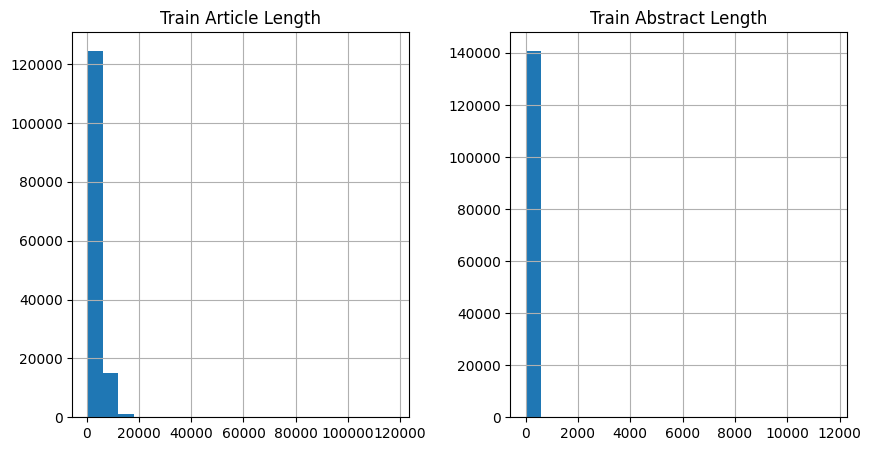

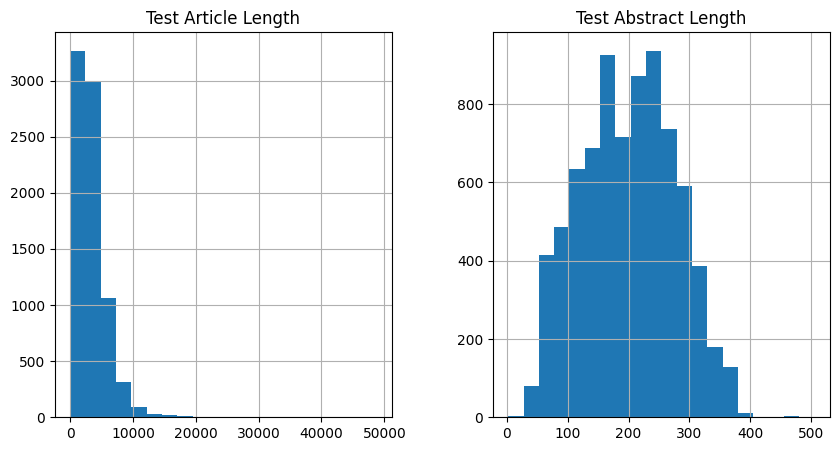

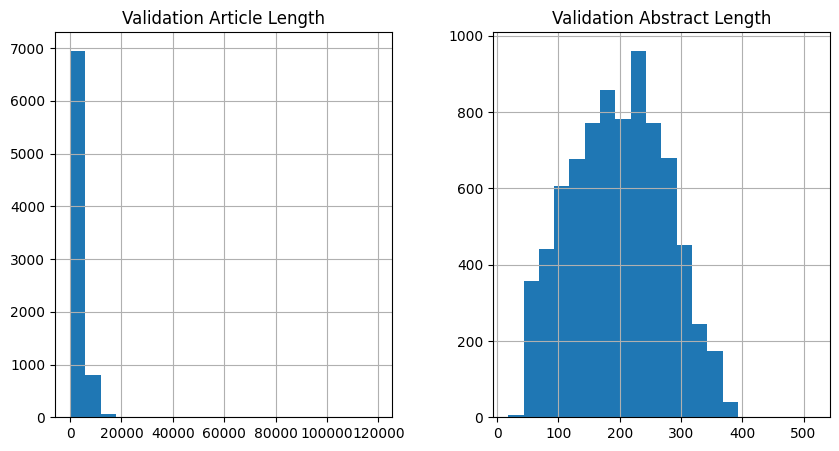

In [ ]:
from datasets import load_dataset
import pandas as pd

# Load the dataset splits
dataset = load_dataset('shruti28062000/test_dataset')

train_split = dataset['train']
test_split = dataset['test']
validation_split = dataset['validation']

# Function to calculate word lengths for the 'article' and 'abstract' fields
def calculate_word_lengths(split):
    article_lengths = [len(example['article'].split()) for example in split]
    abstract_lengths = [len(example['abstract'].split()) for example in split]
    return article_lengths, abstract_lengths

# Calculate word lengths for each split
train_article_lengths, train_abstract_lengths = calculate_word_lengths(train_split)
test_article_lengths, test_abstract_lengths = calculate_word_lengths(test_split)
validation_article_lengths, validation_abstract_lengths = calculate_word_lengths(validation_split)

# Create separate DataFrames for each split
train_data = pd.DataFrame({
    'Train Article Length': train_article_lengths,
    'Train Abstract Length': train_abstract_lengths
})

test_data = pd.DataFrame({
    'Test Article Length': test_article_lengths,
    'Test Abstract Length': test_abstract_lengths
})

validation_data = pd.DataFrame({
    'Validation Article Length': validation_article_lengths,
    'Validation Abstract Length': validation_abstract_lengths
})

# Plot histograms for each split
train_data.hist(figsize=(10, 5), bins=20)
test_data.hist(figsize=(10, 5), bins=20)
validation_data.hist(figsize=(10, 5), bins=20)


# **Testing and Evaluation**

## **Testing finetuned BART model (Recursive function)**

In [ ]:
import torch
import time
import pandas as pd
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM
from datasets import load_dataset, load_metric

# Load the model and tokenizer
device = "cuda" if torch.cuda.is_available() else "cpu"
tokenizer = AutoTokenizer.from_pretrained("shruti28062000/bart_finetuned_papers_4e")
model = AutoModelForSeq2SeqLM.from_pretrained("shruti28062000/bart_finetuned_papers_4e").to(device)

# Function to summarize text using my finetuned BART-CNN model
def summarize(text, max_summary_length=700):
    inputs = tokenizer.encode(text, return_tensors="pt", max_length=1024, truncation=True)
    inputs = inputs.to(device)
    summary_ids = model.generate(
        inputs,
        max_length=max_summary_length,
        min_length=int(max_summary_length / 5),
        length_penalty=8.0,
        num_beams=4,
        early_stopping=True
    )
    summary = tokenizer.decode(summary_ids[0], skip_special_tokens=True)
    return summary

# Function to split text into pieces for summarization
def text_split(text, max_tokens=900, overlap_percent=15):
    tokens = tokenizer.tokenize(text)
    token_overlap = int(max_tokens * overlap_percent / 100)
    pieces = [tokens[i:i + max_tokens] for i in range(0, len(tokens), max_tokens - token_overlap)]
    text_pieces = [tokenizer.decode(tokenizer.convert_tokens_to_ids(piece), skip_special_tokens=True) for piece in pieces]
    return text_pieces

# Function to recursively summarize large text
def recursive_func(text, max_length=700, min_final_length=200, recursion_level=0):
    recursion_level += 1
    tokens = tokenizer.tokenize(text)
    expected_count_of_chunks = len(tokens) / max_length
    if expected_count_of_chunks < 1:
        # If the text is already short enough, summarize it directly
        return summarize(text, max_summary_length=max_length)

    max_chunk_length = int(len(tokens) / expected_count_of_chunks) + 2
    pieces = text_split(text, max_tokens=max_chunk_length)
    summaries = [summarize(piece, max_summary_length=max_chunk_length // 3 * 2) for piece in pieces]
    concatenated_summary = ' '.join(summaries)
    tokens = tokenizer.tokenize(concatenated_summary)

    if len(tokens) > max_length:
        return recursive_func(concatenated_summary, max_length=max_length, min_final_length=min_final_length, recursion_level=recursion_level)
    else:
        if len(tokens) < min_final_length:
            return summarize(concatenated_summary, max_summary_length=max_length)
        else:
            return concatenated_summary

# Load test dataset
test_dataset = load_dataset('shruti28062000/test_dataset', split='test')
dataset_subset = test_dataset.select(range(10))

# Define the ROUGE metric
rouge_metric = load_metric("rouge")

# Generate summaries and compute ROUGE scores
def compute_rouge_scores(dataset):
    results_data = []
    total_generation_time = 0

    for i, example in enumerate(dataset):
        input_text = example['article']
        reference_summary = example['abstract']

        # Calculate article word count
        article_word_count = len(input_text.split())

        # Start timing
        start_time = time.time()

        # Generate summary
        generated_summary = recursive_func(input_text)

        # End timing
        end_time = time.time()
        generation_time = end_time - start_time
        total_generation_time += generation_time

        # Compute ROUGE scores
        rouge_scores = rouge_metric.compute(predictions=[generated_summary], references=[reference_summary])

        # Collect results for each example
        results_data.append({
            'Example': i,
            'Article Length (words)': article_word_count,
            'ROUGE-1': rouge_scores['rouge1'].mid.fmeasure,
            'ROUGE-2': rouge_scores['rouge2'].mid.fmeasure,
            'ROUGE-L': rouge_scores['rougeL'].mid.fmeasure,
            'Generation Time (s)': generation_time
        })

    # Create a DataFrame for the results
    results_df = pd.DataFrame(results_data)

    # Compute and add total generation time
    total_time_data = pd.DataFrame([{
        'Example': 'Total',
        'Article Length (words)': results_df['Article Length (words)'].sum(),
        'ROUGE-1': results_df['ROUGE-1'].mean(),
        'ROUGE-2': results_df['ROUGE-2'].mean(),
        'ROUGE-L': results_df['ROUGE-L'].mean(),
        'Generation Time (s)': total_generation_time
    }])

    results_df = pd.concat([results_df, total_time_data], ignore_index=True)

    # Style the DataFrame
    styled_df = results_df.style.set_table_styles([
        {'selector': 'thead th', 'props': [('font-weight', 'bold')]},
        {'selector': 'th, td', 'props': [('border', '1px solid black')]}
    ])

    return styled_df

# Compute and print ROUGE scores in a styled table
rouge_scores_df = compute_rouge_scores(dataset_subset)
rouge_scores_df


,Example,Article Length (words),ROUGE-1,ROUGE-2,ROUGE-L,Generation Time (s)
0,0,3668,0.460606,0.259635,0.270707,36.838079
1,1,2694,0.191972,0.080560,0.111693,41.612875
2,2,3862,0.399142,0.172414,0.210300,39.931228
3,3,1140,0.256078,0.068293,0.155592,8.977542
4,4,1607,0.181488,0.072860,0.119782,9.415569
5,5,6571,0.308208,0.073950,0.170854,119.197117
6,6,1743,0.192560,0.109890,0.157549,7.807530
7,7,3329,0.359347,0.142077,0.188748,20.808980
8,8,8774,0.409639,0.153226,0.208835,62.320883
9,9,880,0.377358,0.120253,0.182390,4.122658


## **Testing finetuned BART model (Recursive function with Accelerate)**

In [ ]:
import torch
import time
import pandas as pd
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM
from datasets import load_dataset, load_metric
from accelerate import Accelerator

# Initialize Accelerator
accelerator = Accelerator()

# Load the model and tokenizer
tokenizer = AutoTokenizer.from_pretrained("shruti28062000/bart_finetuned_papers_4e")
model = AutoModelForSeq2SeqLM.from_pretrained("shruti28062000/bart_finetuned_papers_4e")

# Move model to the appropriate device using Accelerator
model = accelerator.prepare(model)

# Function to summarize text using the BART model
def summarize(text, max_summary_length=700):
    inputs = tokenizer.encode(text, return_tensors="pt", max_length=1024, truncation=True)
    inputs = inputs.to(accelerator.device)  # Use the device from accelerator
    summary_ids = model.generate(
        inputs,
        max_length=max_summary_length,
        min_length=int(max_summary_length / 5),
        length_penalty=8.0,
        num_beams=4,
        early_stopping=True
    )
    summary = tokenizer.decode(summary_ids[0], skip_special_tokens=True)
    return summary

# Function to split text into pieces for summarization
def text_split(text, max_tokens=900, overlap_percent=15):
    tokens = tokenizer.tokenize(text)
    token_overlap = int(max_tokens * overlap_percent / 100)
    pieces = [tokens[i:i + max_tokens] for i in range(0, len(tokens), max_tokens - token_overlap)]
    text_pieces = [tokenizer.decode(tokenizer.convert_tokens_to_ids(piece), skip_special_tokens=True) for piece in pieces]
    return text_pieces

# Function to recursively summarize large text
def recursive_func(text, max_length=700, min_final_length=200, recursion_level=0):
    recursion_level += 1
    tokens = tokenizer.tokenize(text)
    expected_count_of_chunks = len(tokens) / max_length
    if expected_count_of_chunks < 1:
        return summarize(text, max_summary_length=max_length)

    max_chunk_length = int(len(tokens) / expected_count_of_chunks) + 2
    pieces = text_split(text, max_tokens=max_chunk_length)
    summaries = [summarize(piece, max_summary_length=max_chunk_length // 3 * 2) for piece in pieces]
    concatenated_summary = ' '.join(summaries)
    tokens = tokenizer.tokenize(concatenated_summary)

    if len(tokens) > max_length:
        return recursive_func(concatenated_summary, max_length=max_length, min_final_length=min_final_length, recursion_level=recursion_level)
    else:
        if len(tokens) < min_final_length:
            return summarize(concatenated_summary, max_summary_length=max_length)
        else:
            return concatenated_summary

# Load test dataset
test_dataset = load_dataset('shruti28062000/test_dataset', split='test')
dataset_subset = test_dataset.select(range(10))

# Define the ROUGE metric
rouge_metric = load_metric("rouge")

# Generate summaries and compute ROUGE scores
def compute_rouge_scores(dataset):
    results_data = []
    total_generation_time = 0

    for i, example in enumerate(dataset):
        input_text = example['article']
        reference_summary = example['abstract']

        # Calculate article word count
        article_word_count = len(input_text.split())

        # Start timing
        start_time = time.time()

        # Generate summary
        generated_summary = recursive_func(input_text)

        # End timing
        end_time = time.time()
        generation_time = end_time - start_time
        total_generation_time += generation_time

        # Compute ROUGE scores
        rouge_scores = rouge_metric.compute(predictions=[generated_summary], references=[reference_summary])

        # Collect results for each example
        results_data.append({
            'Example': i,
            'Article Length (words)': article_word_count,
            'ROUGE-1': rouge_scores['rouge1'].mid.fmeasure,
            'ROUGE-2': rouge_scores['rouge2'].mid.fmeasure,
            'ROUGE-L': rouge_scores['rougeL'].mid.fmeasure,
            'Generation Time (s)': generation_time
        })

    # Create a DataFrame for the results
    results_df = pd.DataFrame(results_data)

    # Compute and add total generation time
    total_time_data = pd.DataFrame([{
        'Example': 'Total',
        'Article Length (words)': results_df['Article Length (words)'].sum(),
        'ROUGE-1': results_df['ROUGE-1'].mean(),
        'ROUGE-2': results_df['ROUGE-2'].mean(),
        'ROUGE-L': results_df['ROUGE-L'].mean(),
        'Generation Time (s)': total_generation_time
    }])

    results_df = pd.concat([results_df, total_time_data], ignore_index=True)

    # Style the DataFrame
    styled_df = results_df.style.set_table_styles([
        {'selector': 'thead th', 'props': [('font-weight', 'bold')]},
        {'selector': 'th, td', 'props': [('border', '1px solid black')]}
    ])

    return styled_df

# Compute and print ROUGE
rouge_scores_df = compute_rouge_scores(dataset_subset)
rouge_scores_df


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/1.43k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/798k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.11M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/957 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.66k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.63G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/328 [00:00<?, ?B/s]

Generating train split:   0%|          | 0/141294 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/7795 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/7824 [00:00<?, ? examples/s]

<ipython-input-2-635db5cad7b7>:68: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  rouge_metric = load_metric("rouge")


The repository for rouge contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/rouge.
You can avoid this prompt in future by passing the argument `trust_remote_code=True`.

Do you wish to run the custom code? [y/N] y


,Example,Article Length (words),ROUGE-1,ROUGE-2,ROUGE-L,Generation Time (s)
0,0,3668,0.460606,0.259635,0.270707,33.234948
1,1,2694,0.191972,0.080560,0.111693,42.208552
2,2,3862,0.399142,0.172414,0.210300,39.097998
3,3,1140,0.256078,0.068293,0.155592,8.193101
4,4,1607,0.181488,0.072860,0.119782,8.898510
5,5,6571,0.308208,0.073950,0.170854,115.907932
6,6,1743,0.192560,0.109890,0.157549,7.900105
7,7,3329,0.359347,0.142077,0.188748,20.631499
8,8,8774,0.409639,0.153226,0.208835,62.211353
9,9,880,0.377358,0.120253,0.182390,3.834466


## **Testing finetuned BART model (with memoization)**

In [ ]:
import torch
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM
from concurrent.futures import ThreadPoolExecutor
from functools import lru_cache
import nltk
# import fitz  # PyMuPDF for PDF handling
from accelerate import Accelerator
from datasets import load_dataset, load_metric
import time
import pandas as pd

# Ensure you have the required packages
nltk.download('punkt')

# Initialize Accelerate
accelerator = Accelerator()

# Initialize BART model and tokenizer
device = "cuda" if torch.cuda.is_available() else "cpu"
tokenizer = AutoTokenizer.from_pretrained("shruti28062000/bart_finetuned_papers_4e")
model = AutoModelForSeq2SeqLM.from_pretrained("shruti28062000/bart_finetuned_papers_4e").to(device)

# Move the model to the appropriate device with Accelerate
model = accelerator.prepare(model)

# Memoized function to summarize text using BART model
@lru_cache(maxsize=None)
def summarize(text, max_summary_length=700):
    inputs = tokenizer.encode(text, return_tensors="pt", max_length=1024, truncation=True)
    inputs = inputs.to(accelerator.device)  # Use Accelerate device
    summary_ids = model.generate(
        inputs,
        max_length=max_summary_length,
        min_length=int(max_summary_length / 5),
        length_penalty=8.0,
        num_beams=4,
        early_stopping=True
    )
    summary = tokenizer.decode(summary_ids[0], skip_special_tokens=True)
    return summary

# Function to split text into pieces for summarization
def text_split(text, max_tokens=900, overlap_percent=15):
    tokens = tokenizer.tokenize(text)
    token_overlap = int(max_tokens * overlap_percent / 100)
    pieces = [tokens[i:i + max_tokens] for i in range(0, len(tokens), max_tokens - token_overlap)]
    text_pieces = [tokenizer.decode(tokenizer.convert_tokens_to_ids(piece), skip_special_tokens=True) for piece in pieces]
    return text_pieces

# Enhanced recursive summarization function
def recursive_func(text, max_length=700, min_final_length=200, recursion_level=0):
    recursion_level += 1
    tokens = tokenizer.tokenize(text)
    expected_count_of_chunks = len(tokens) / max_length

    # Base case: If the text is already short enough, summarize it directly
    if expected_count_of_chunks < 1:
        return summarize(text, max_summary_length=max_length)

    # Calculate chunk length and split text with dynamic adjustment
    max_chunk_length = int(len(tokens) / expected_count_of_chunks) + 2
    pieces = text_split(text, max_tokens=max_chunk_length)

    # Summarize each chunk in parallel
    with ThreadPoolExecutor() as executor:
        summaries = list(executor.map(lambda piece: summarize(piece, max_summary_length=max_chunk_length // 3 * 2), pieces))

    concatenated_summary = ' '.join(summaries)

    # Recursively reduce summary length if needed
    tokens = tokenizer.tokenize(concatenated_summary)
    if len(tokens) > max_length:
        return recursive_func(concatenated_summary, max_length=max_length, min_final_length=min_final_length, recursion_level=recursion_level)
    else:
        # Final summarization to ensure the summary fits within limits
        if len(tokens) < min_final_length:
            return summarize(concatenated_summary, max_summary_length=max_length)
        else:
            return concatenated_summary

# Load test dataset
test_dataset = load_dataset('shruti28062000/test_dataset', split='test')
dataset_subset = test_dataset.select(range(10))

# Define the ROUGE metric
rouge_metric = load_metric("rouge")

# Generate summaries and compute ROUGE scores
def compute_rouge_scores(dataset):
    results_data = []
    total_generation_time = 0

    for i, example in enumerate(dataset):
        input_text = example['article']
        reference_summary = example['abstract']

        # Calculate article word count
        article_word_count = len(input_text.split())

        # Start timing
        start_time = time.time()

        # Generate summary
        generated_summary = recursive_func(input_text)

        # End timing
        end_time = time.time()
        generation_time = end_time - start_time
        total_generation_time += generation_time

        # Compute ROUGE scores
        rouge_scores = rouge_metric.compute(predictions=[generated_summary], references=[reference_summary])

        # Collect results for each example
        results_data.append({
            'Example': i,
            'Article Length (words)': article_word_count,
            'ROUGE-1': rouge_scores['rouge1'].mid.fmeasure,
            'ROUGE-2': rouge_scores['rouge2'].mid.fmeasure,
            'ROUGE-L': rouge_scores['rougeL'].mid.fmeasure,
            'Generation Time (s)': generation_time
        })

    # Create a DataFrame for the results
    results_df = pd.DataFrame(results_data)

    # Compute and add total generation time
    total_time_data = pd.DataFrame([{
        'Example': 'Total',
        'Article Length (words)': results_df['Article Length (words)'].sum(),
        'ROUGE-1': results_df['ROUGE-1'].mean(),
        'ROUGE-2': results_df['ROUGE-2'].mean(),
        'ROUGE-L': results_df['ROUGE-L'].mean(),
        'Generation Time (s)': total_generation_time
    }])

    results_df = pd.concat([results_df, total_time_data], ignore_index=True)

    # Style the DataFrame
    styled_df = results_df.style.set_table_styles([
        {'selector': 'thead th', 'props': [('font-weight', 'bold')]},
        {'selector': 'th, td', 'props': [('border', '1px solid black')]}
    ])

    return styled_df

# Compute and print ROUGE scores in a styled table
rouge_scores_df = compute_rouge_scores(dataset_subset)
rouge_scores_df


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
<ipython-input-5-36e3724073a7>:86: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  rouge_metric = load_metric("rouge")


,Example,Article Length (words),ROUGE-1,ROUGE-2,ROUGE-L,Generation Time (s)
0,0,3668,0.460606,0.259635,0.270707,38.861328
1,1,2694,0.191972,0.080560,0.111693,48.770535
2,2,3862,0.399142,0.172414,0.210300,46.656940
3,3,1140,0.256078,0.068293,0.155592,11.189458
4,4,1607,0.181488,0.072860,0.119782,10.683679
5,5,6571,0.308208,0.073950,0.170854,138.557007
6,6,1743,0.192560,0.109890,0.157549,9.026296
7,7,3329,0.359347,0.142077,0.188748,25.533526
8,8,8774,0.409639,0.153226,0.208835,75.874284
9,9,880,0.377358,0.120253,0.182390,4.113607


## **Memoization with Accelerate and Parallel Processing**

In [ ]:
import torch
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM
from concurrent.futures import ThreadPoolExecutor
from functools import lru_cache
import nltk
from accelerate import Accelerator
from datasets import load_dataset, load_metric
import time
import pandas as pd

# Ensure you have the required packages
nltk.download('punkt')

# Initialize Accelerate
accelerator = Accelerator()

# Initialize BART model and tokenizer
tokenizer = AutoTokenizer.from_pretrained("shruti28062000/bart_finetuned_papers_4e")
model = AutoModelForSeq2SeqLM.from_pretrained("shruti28062000/bart_finetuned_papers_4e")

# Prepare model using Accelerate
model = accelerator.prepare(model)

# Memoized function to summarize text using BART model
@lru_cache(maxsize=None)
def summarize(text, max_summary_length=700):
    inputs = tokenizer.encode(text, return_tensors="pt", max_length=1024, truncation=True)
    inputs = inputs.to(accelerator.device)  # Use Accelerate device
    summary_ids = model.generate(
        inputs,
        max_length=max_summary_length,
        min_length=int(max_summary_length / 5),
        length_penalty=8.0,
        num_beams=4,
        early_stopping=True
    )
    summary = tokenizer.decode(summary_ids[0], skip_special_tokens=True)
    return summary

# Function to split text into pieces for summarization
def text_split(text, max_tokens=900, overlap_percent=15):
    tokens = tokenizer.tokenize(text)
    token_overlap = int(max_tokens * overlap_percent / 100)
    pieces = [tokens[i:i + max_tokens] for i in range(0, len(tokens), max_tokens - token_overlap)]
    text_pieces = [tokenizer.decode(tokenizer.convert_tokens_to_ids(piece), skip_special_tokens=True) for piece in pieces]
    return text_pieces

# Enhanced recursive summarization function
def recursive_func(text, max_length=700, min_final_length=200, recursion_level=0):
    recursion_level += 1
    tokens = tokenizer.tokenize(text)
    expected_count_of_chunks = len(tokens) / max_length

    if expected_count_of_chunks < 1:
        return summarize(text, max_summary_length=max_length)

    max_chunk_length = int(len(tokens) / expected_count_of_chunks) + 2
    pieces = text_split(text, max_tokens=max_chunk_length)

    with ThreadPoolExecutor() as executor:
        summaries = list(executor.map(lambda piece: summarize(piece, max_summary_length=max_chunk_length // 3 * 2), pieces))

    concatenated_summary = ' '.join(summaries)
    tokens = tokenizer.tokenize(concatenated_summary)

    if len(tokens) > max_length:
        return recursive_func(concatenated_summary, max_length=max_length, min_final_length=min_final_length, recursion_level=recursion_level)
    else:
        if len(tokens) < min_final_length:
            return summarize(concatenated_summary, max_summary_length=max_length)
        else:
            return concatenated_summary

# Load test dataset and prepare it with accelerate
test_dataset = load_dataset('shruti28062000/test_dataset', split='test')
dataset_subset = accelerator.prepare(test_dataset.select(range(10)))

# Define the ROUGE metric
rouge_metric = load_metric("rouge")

# Generate summaries and compute ROUGE scores
def compute_rouge_scores(dataset):
    results_data = []
    total_generation_time = 0

    for i, example in enumerate(dataset):
        input_text = example['article']
        reference_summary = example['abstract']

        article_word_count = len(input_text.split())

        start_time = time.time()

        generated_summary = recursive_func(input_text)

        end_time = time.time()
        generation_time = end_time - start_time
        total_generation_time += generation_time

        rouge_scores = rouge_metric.compute(predictions=[generated_summary], references=[reference_summary])

        results_data.append({
            'Example': i,
            'Article Length (words)': article_word_count,
            'ROUGE-1': rouge_scores['rouge1'].mid.fmeasure,
            'ROUGE-2': rouge_scores['rouge2'].mid.fmeasure,
            'ROUGE-L': rouge_scores['rougeL'].mid.fmeasure,
            'Generation Time (s)': generation_time
        })

    results_df = pd.DataFrame(results_data)

    total_time_data = pd.DataFrame([{
        'Example': 'Total',
        'Article Length (words)': results_df['Article Length (words)'].sum(),
        'ROUGE-1': results_df['ROUGE-1'].mean(),
        'ROUGE-2': results_df['ROUGE-2'].mean(),
        'ROUGE-L': results_df['ROUGE-L'].mean(),
        'Generation Time (s)': total_generation_time
    }])

    results_df = pd.concat([results_df, total_time_data], ignore_index=True)

    styled_df = results_df.style.set_table_styles([
        {'selector': 'thead th', 'props': [('font-weight', 'bold')]},
        {'selector': 'th, td', 'props': [('border', '1px solid black')]}
    ])

    return styled_df

rouge_scores_df = compute_rouge_scores(dataset_subset)
rouge_scores_df


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/1.43k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/798k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.11M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/957 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.66k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.63G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/328 [00:00<?, ?B/s]

Generating train split:   0%|          | 0/141294 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/7795 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/7824 [00:00<?, ? examples/s]

<ipython-input-2-f8cdb79dcf31>:79: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  rouge_metric = load_metric("rouge")


The repository for rouge contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/rouge.
You can avoid this prompt in future by passing the argument `trust_remote_code=True`.

Do you wish to run the custom code? [y/N] y


,Example,Article Length (words),ROUGE-1,ROUGE-2,ROUGE-L,Generation Time (s)
0,0,3668,0.460606,0.259635,0.270707,38.728966
1,1,2694,0.191972,0.080560,0.111693,46.187530
2,2,3862,0.399142,0.172414,0.210300,45.166456
3,3,1140,0.256078,0.068293,0.155592,9.484621
4,4,1607,0.181488,0.072860,0.119782,10.154625
5,5,6571,0.308208,0.073950,0.170854,133.232410
6,6,1743,0.192560,0.109890,0.157549,8.607020
7,7,3329,0.359347,0.142077,0.188748,24.589276
8,8,8774,0.409639,0.153226,0.208835,75.075155
9,9,880,0.377358,0.120253,0.182390,3.764134


## **Testing further finetuned BART model**

In [ ]:
import torch
import time
import pandas as pd
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM
from datasets import load_dataset, load_metric

# Load the model and tokenizer
device = "cuda" if torch.cuda.is_available() else "cpu"
tokenizer = AutoTokenizer.from_pretrained("shruti28062000/bart_further_finetuned_3e")
model = AutoModelForSeq2SeqLM.from_pretrained("shruti28062000/bart_further_finetuned_3e").to(device)

# Function to summarize text using my finetuned BART-CNN model
def summarize(text, max_summary_length=700):
    inputs = tokenizer.encode(text, return_tensors="pt", max_length=1024, truncation=True)
    inputs = inputs.to(device)
    summary_ids = model.generate(
        inputs,
        max_length=max_summary_length,
        min_length=int(max_summary_length / 5),
        length_penalty=8.0,
        num_beams=4,
        early_stopping=True
    )
    summary = tokenizer.decode(summary_ids[0], skip_special_tokens=True)
    return summary

# Function to split text into pieces for summarization
def text_split(text, max_tokens=900, overlap_percent=15):
    tokens = tokenizer.tokenize(text)
    token_overlap = int(max_tokens * overlap_percent / 100)
    pieces = [tokens[i:i + max_tokens] for i in range(0, len(tokens), max_tokens - token_overlap)]
    text_pieces = [tokenizer.decode(tokenizer.convert_tokens_to_ids(piece), skip_special_tokens=True) for piece in pieces]
    return text_pieces

# Function to recursively summarize large text
def recursive_func(text, max_length=700, min_final_length=200, recursion_level=0):
    recursion_level += 1
    tokens = tokenizer.tokenize(text)
    expected_count_of_chunks = len(tokens) / max_length
    if expected_count_of_chunks < 1:
        # If the text is already short enough, summarize it directly
        return summarize(text, max_summary_length=max_length)

    max_chunk_length = int(len(tokens) / expected_count_of_chunks) + 2
    pieces = text_split(text, max_tokens=max_chunk_length)
    summaries = [summarize(piece, max_summary_length=max_chunk_length // 3 * 2) for piece in pieces]
    concatenated_summary = ' '.join(summaries)
    tokens = tokenizer.tokenize(concatenated_summary)

    if len(tokens) > max_length:
        return recursive_func(concatenated_summary, max_length=max_length, min_final_length=min_final_length, recursion_level=recursion_level)
    else:
        if len(tokens) < min_final_length:
            return summarize(concatenated_summary, max_summary_length=max_length)
        else:
            return concatenated_summary

# Load test dataset
test_dataset = load_dataset('shruti28062000/test_dataset', split='test')
dataset_subset = test_dataset.select(range(10))

# Define the ROUGE metric
rouge_metric = load_metric("rouge")

# Generate summaries and compute ROUGE scores
def compute_rouge_scores(dataset):
    results_data = []
    total_generation_time = 0

    for i, example in enumerate(dataset):
        input_text = example['article']
        reference_summary = example['abstract']

        # Calculate article word count
        article_word_count = len(input_text.split())

        # Start timing
        start_time = time.time()

        # Generate summary
        generated_summary = recursive_func(input_text)

        # End timing
        end_time = time.time()
        generation_time = end_time - start_time
        total_generation_time += generation_time

        # Compute ROUGE scores
        rouge_scores = rouge_metric.compute(predictions=[generated_summary], references=[reference_summary])

        # Collect results for each example
        results_data.append({
            'Example': i,
            'Article Length (words)': article_word_count,
            'ROUGE-1': rouge_scores['rouge1'].mid.fmeasure,
            'ROUGE-2': rouge_scores['rouge2'].mid.fmeasure,
            'ROUGE-L': rouge_scores['rougeL'].mid.fmeasure,
            'Generation Time (s)': generation_time
        })

    # Create a DataFrame for the results
    results_df = pd.DataFrame(results_data)

    # Compute and add total generation time
    total_time_data = pd.DataFrame([{
        'Example': 'Total',
        'Article Length (words)': results_df['Article Length (words)'].sum(),
        'ROUGE-1': results_df['ROUGE-1'].mean(),
        'ROUGE-2': results_df['ROUGE-2'].mean(),
        'ROUGE-L': results_df['ROUGE-L'].mean(),
        'Generation Time (s)': total_generation_time
    }])

    results_df = pd.concat([results_df, total_time_data], ignore_index=True)


    styled_df = results_df.style.set_table_styles([
        {'selector': 'thead th', 'props': [('font-weight', 'bold')]},
        {'selector': 'th, td', 'props': [('border', '1px solid black')]}
    ])

    return styled_df

# Compute and print ROUGE scores in a styled table
rouge_scores_df = compute_rouge_scores(dataset_subset)
rouge_scores_df


,Example,Article Length (words),ROUGE-1,ROUGE-2,ROUGE-L,Generation Time (s)
0,0,3668,0.460606,0.259635,0.270707,29.504685
1,1,2694,0.191972,0.080560,0.111693,43.120107
2,2,3862,0.399142,0.172414,0.210300,40.465552
3,Total,10224,0.350573,0.170870,0.197567,113.090344


## **Testing LED model**

In [ ]:
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM
from datasets import load_dataset, load_metric
import torch
import pandas as pd
import time

# Check for GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Load the tokenizer and model
tokenizer = AutoTokenizer.from_pretrained("allenai/led-base-16384")
model = AutoModelForSeq2SeqLM.from_pretrained("allenai/led-base-16384")
model.to(device)

# Load the ROUGE metric
rouge = load_metric("rouge")

# Load the dataset
dataset = load_dataset("shruti28062000/test_dataset", split="test")
dataset = dataset.select(range(10))

# Initialize total computation time counter
total_generation_time = 0

# Initialize list to store results for each example
results_data = []

# Process each example in the dataset
for i, example in enumerate(dataset):
    article = example['article']
    reference_summary = example['abstract']

    # Tokenize the article and reference summary
    article_tokens = tokenizer.tokenize(article)

    # Calculate article word count
    article_word_count = len(article.split())

    # Start timing
    start_time = time.time()

    inputs_dict = tokenizer(article, padding="max_length", max_length=16384, return_tensors="pt", truncation=True)
    input_ids = inputs_dict['input_ids'].to(device)
    attention_mask = inputs_dict['attention_mask'].to(device)
    global_attention_mask = torch.zeros_like(attention_mask)
    global_attention_mask[:, 0] = 1  # Set global attention on the first token

    # Generate the summary
    predicted_abstract = model.generate(input_ids,
                                        attention_mask=attention_mask,
                                        global_attention_mask=global_attention_mask,
                                        decoder_start_token_id=model.config.pad_token_id,
                                        do_sample=False,
                                        max_length=700,
                                        temperature=1.0)

    # Decode summary
    summary = tokenizer.decode(predicted_abstract[0], skip_special_tokens=True)

    # End timing
    end_time = time.time()
    generation_time = end_time - start_time
    total_generation_time += generation_time

    # Compute ROUGE score
    rouge_scores = rouge.compute(predictions=[summary], references=[reference_summary])

    # Store results
    results_data.append({
        'Example': i,
        'Article Length (words)': article_word_count,
        'ROUGE-1': rouge_scores['rouge1'].mid.fmeasure,
        'ROUGE-2': rouge_scores['rouge2'].mid.fmeasure,
        'ROUGE-L': rouge_scores['rougeL'].mid.fmeasure,
        'Generation Time (s)': generation_time
    })

# Create DataFrame for results
results_df = pd.DataFrame(results_data)

# Compute and add total generation time
total_time_data = pd.DataFrame([{
    'Example': 'Total',
    'Article Length (words)': results_df['Article Length (words)'].sum(),
    'ROUGE-1': results_df['ROUGE-1'].mean(),
    'ROUGE-2': results_df['ROUGE-2'].mean(),
    'ROUGE-L': results_df['ROUGE-L'].mean(),
    'Generation Time (s)': total_generation_time
}])

results_df = pd.concat([results_df, total_time_data], ignore_index=True)


styled_df = results_df.style.set_table_styles([
    {'selector': 'thead th', 'props': [('font-weight', 'bold')]},
    {'selector': 'th, td', 'props': [('border', '1px solid black')]}
])


styled_df


tokenizer_config.json:   0%|          | 0.00/27.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.09k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/772 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/648M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/168 [00:00<?, ?B/s]

,Example,Article Length (words),ROUGE-1,ROUGE-2,ROUGE-L,Generation Time (s)
0,0,3668,0.250712,0.088571,0.150997,6.116089
1,Total,3668,0.250712,0.088571,0.150997,6.116089
